# Visualize and preprocess
Now that we've separated our data into the training, cross-validation and test set we can start to look in more detail at the data we've been provided by Google Brain & Kaggle. 

We should bear in mind that we've also copied a small portion of our _main_ data into a _sample_ folder, which is also structured into train, cv and test subsets. Additionally our dataset in the main section is **currently unbalanced** in that we have:

   1. A lot more examples in the _unknown_ category than other categories for train, cv & test sets.
   2. A lot fewer examples in the _silence_ category than other categories for train, cv & test sets.

In the _sample_ set we have a balanced mix. 

In [71]:
# first make sure we're in the parent dictory of our data/main folders.
!pwd

/c/Users/mateusz/Documents/Mateusz/Career/Machine Learning & AI/tensorflow_speech_recognition/tensorflow_speech_recognition


## Import
We'll need a couple of additional libraries so let's import them.

In [72]:
import IPython.display
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import os

from scipy.io import wavfile

In [73]:
# we'll only want to see certain warnings once or not at all (stops them from polluting the notebook)
# particularly the ones about future deprecations in our dependencies
import warnings
warnings.filterwarnings('ignore') 

# to see them just once uncomment the line below
# warnings.filterwarnings('once')

## Utils
Define useful functions.

In [74]:
def display_audio(path_to_wav):
    """
    Simple function for displaying playable audio files in jupyter.
    """
    # get rate and data
    r, d = get_wav_info(path_to_wav)
    # show playable audio
    return IPython.display.Audio(data=d, rate=r)

def get_wav_info(wav_file):
    """
    Read a wav file returning the sample rate (number of audio samples per second, in Hz) and the actual raw data.
    """
    rate, data = wavfile.read(wav_file)
    return rate, data

For a waveform representation.

In [75]:
def graph_waveform(wav_file):
    data, sampling_rate = librosa.load(wav_file)
    plt.figure(figsize=(12, 4))
    librosa.display.waveplot(data, sr=sampling_rate)

For the pyplot spectrogram.

In [76]:
def graph_spectrogram(wav_file, size=(10,6)):
    """
    Draw a graph of a spectrogram using pyplot.
    """
    rate, data = get_wav_info(wav_file)
    nfft = 256    # windowing segments length
    fs = 16000    # sampling frequency of our files is 16000
    plt.figure(figsize=size)
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.title('Spectrogram of {}'.format(wav_file))
    pxx, freqs, bins, im = plt.specgram(data, nfft,fs)

For the librosa mel spectrogram.

In [77]:
def graph_mel_spectrogram(wav_file):
    """
    Draw a graph of a mel spectrogram using librosa.
    """
    y, sr = librosa.load(wav_file)
    S = librosa.feature.melspectrogram(y, sr=sr)

    # Convert to log scale (dB). We'll use the peak power (max) as reference.
    log_S = librosa.power_to_db(S, ref=np.max)

    # Make a new figure
    plt.figure(figsize=(10,6))

    # Display the spectrogram on a mel scale
    # sample rate and hop length parameters are used to render the time axis
    librosa.display.specshow(librosa.power_to_db(S,ref=np.max),
                         y_axis='mel', fmax=32000,
                         x_axis='time')

    # Descriptions
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.title('Mel spectrogram of {}'.format(wav_file))

    # draw a color bar
    plt.colorbar(format='%+02.0f dB')

    # Make the figure layout compact
    plt.tight_layout()

For visualizing multiple MEL spectrograms side by side (on a default 3x3 grid). This gives us a bird's eye overview of e.g. 9 spectrograms belonging to the same category, which makes it easier to see common patterns.

In [99]:
def graph_multiple_mel_spectrograms(list_of_wavs, grid_dimensions=(3,3)):
    """
    Draw multiple graphs of mel spectrograms side by side.
    """
    
    # Assume 3x3 grid maximum
    grid_height = grid_dimensions[0]
    grid_width = grid_dimensions[1]
    
    # Create a figure for all subplots
    plt.figure(figsize=(24,18))
    
    for idx, wav_file in enumerate(list_of_wavs):
        
        y, sr = librosa.load(wav_file)
        S = librosa.feature.melspectrogram(y, sr=sr)
        log_S = librosa.power_to_db(S, ref=np.max)

        # Subplot
        plt.subplot(grid_height, grid_width, idx + 1)

        # Display the spectrogram on a mel scale
        librosa.display.specshow(librosa.power_to_db(S,ref=np.max),
                             y_axis='mel', fmax=32000,
                             x_axis='time')

        # Describe
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [sec]')
        plt.title('{}'.format(wav_file))

## Visualize
Let's turn audio files into something visible.

We will try out waveforms and spectrograms. A spectrogram is a visual representation of the spectrum of frequencies in a sound. Horizontal axis represents time, vertical axis represents the frequency, and the color represents amplitude.

In [78]:
# grab a sample file
path_to_sample = "data\\sample"
path_to_a_wav = os.path.join(path_to_sample, "cv\\unknown\\9db2bfe9_nohash_4_five.wav")

In [79]:
# let's listen to it first
display_audio(path_to_a_wav)

The simplest representation of the wav file is a waveform, which is closest to what the original wav file actually is.

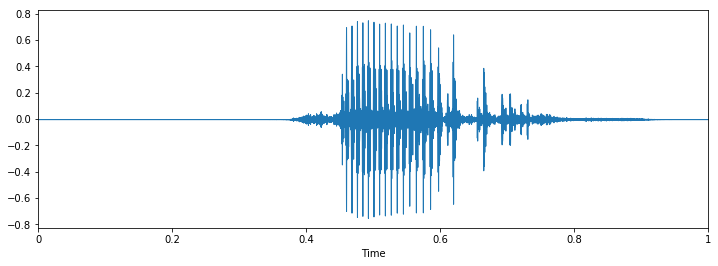

In [80]:
graph_waveform(path_to_a_wav)

Another way of visualizing an audio file is a spectrogram.

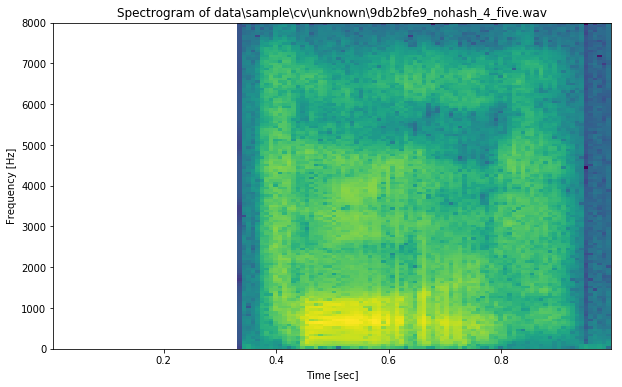

In [81]:
# show spectrogram (pyplot version)
graph_spectrogram(path_to_a_wav)

We can also use a **mel spectrogram** through librosa, here we can see that the frequency scale is logarithmic and that librosa handles 0s in the data better. With the example of sample\cv\unknown\9db2bfe9_nohash_4_five.wav we can see that using pyplot leaves zeros white on the graph, whereas librosa treats them as silence and draws them black. 

This could be a useful property if we plan on using the spectrogram images as our actual training examples and use convolutions on them.

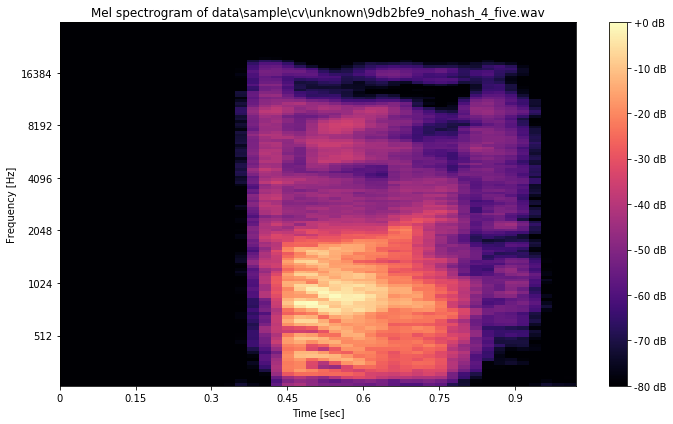

In [82]:
# graph librosa mel spectrogram
graph_mel_spectrogram(path_to_a_wav)

### Visualize a larger sample
We can gain a lot of insight from looking at our data, let's try to use the techniques above to visualize an example from each of the categories that we'll be trying to predict. If we can visually tell each category apart then we can be more optimistic about using an image classification algorithm.

We can also display a number of examples from each category and try to see if they look similar enough.

#### Waveforms
Let's start by picking 3 waveforms from one category and see if we can see a visual similarity. 

In [83]:
# set up paths to sample files
path_to_down_1 = os.path.join(path_to_sample, "cv\\down\\471a0925_nohash_3.wav")
path_to_down_2 = os.path.join(path_to_sample, "cv\\down\\1942abd7_nohash_0.wav")
path_to_down_3 = os.path.join(path_to_sample, "cv\\down\\db43cd03_nohash_0.wav")

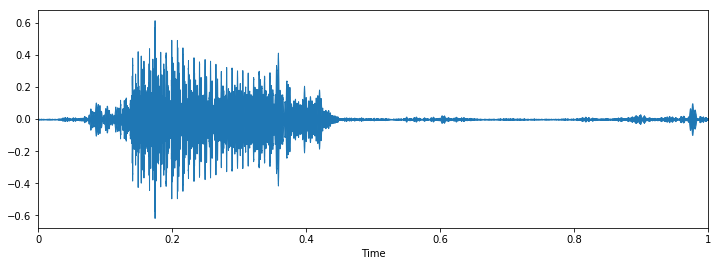

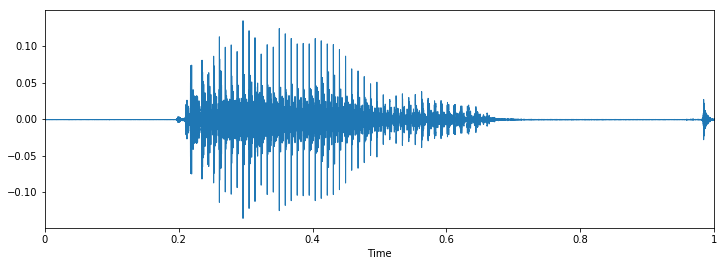

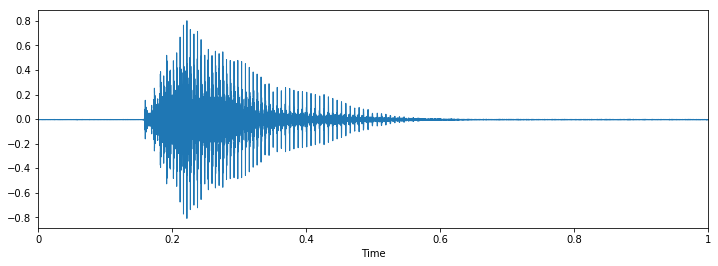

In [84]:
# graph waveforms
graph_waveform(path_to_down_1)
graph_waveform(path_to_down_2)
graph_waveform(path_to_down_3)

Ok, it looks like there could be a certain arrowhead-like pattern to the way we say "down". 
Let's pick 3 examples from a different category to determine if they are both a) similar to each other b) different from the waveforms of the "down" category.

In [85]:
# set up paths to sample files
path_to_right_1 = os.path.join(path_to_sample, "cv\\right\\6b81fead_nohash_0.wav")
path_to_right_2 = os.path.join(path_to_sample, "cv\\right\\97ae8b25_nohash_0.wav")
path_to_right_3 = os.path.join(path_to_sample, "cv\\right\\d197e3ae_nohash_2.wav")

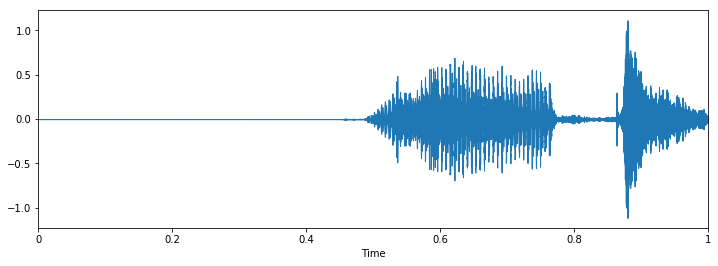

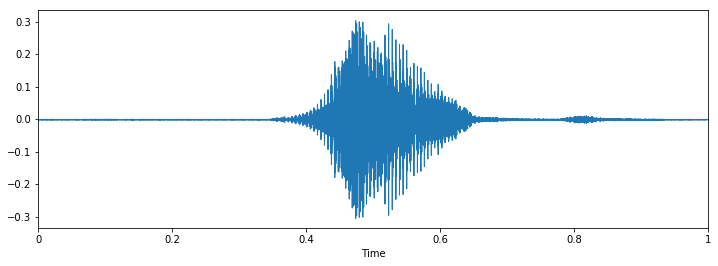

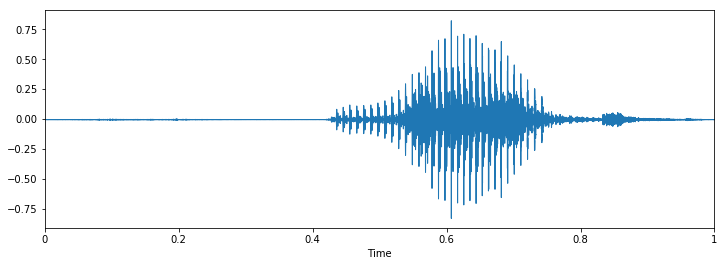

In [86]:
# graph waveforms
graph_waveform(path_to_right_1)
graph_waveform(path_to_right_2)
graph_waveform(path_to_right_3)

There seems to be a discernible pattern to the way "right" looks as a waveform - a larger blob followed by a smaller spike occuring approximately 0.1 second after the main part. Let's look at another category just to be sure.

In [87]:
# set up paths to sample files
path_to_no_1 = os.path.join(path_to_sample, "cv\\no\\9db2bfe9_nohash_1.wav")
path_to_no_2 = os.path.join(path_to_sample, "cv\\no\\264f471d_nohash_2.wav")
path_to_no_3 = os.path.join(path_to_sample, "cv\\no\\7117fb6d_nohash_2.wav")

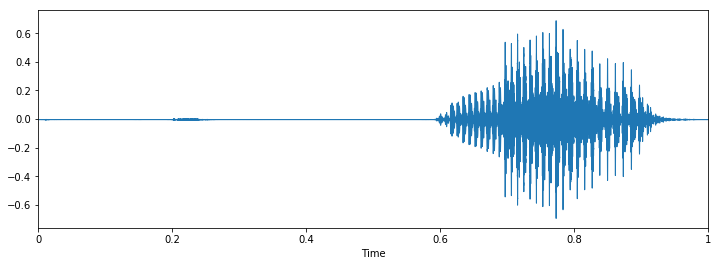

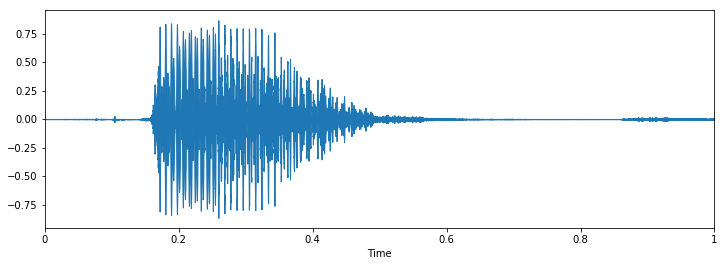

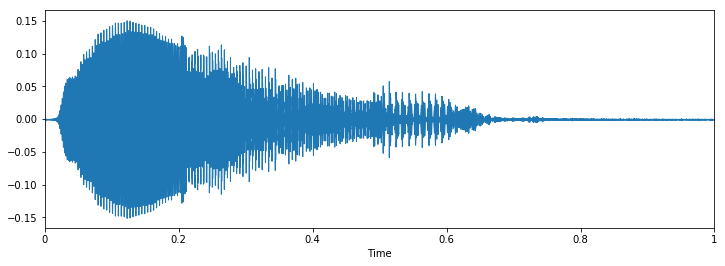

In [88]:
# graph waveforms
graph_waveform(path_to_no_1)
graph_waveform(path_to_no_2)
graph_waveform(path_to_no_3)

Upon further inspection it looks like the waveforms might not be distinguishable enough.
Let's put spectrograms throughthe same test.

#### Spectrograms
We already have our 9 sample files from 3 categories - "down", "right" and "no". Let's visualize the graphs.

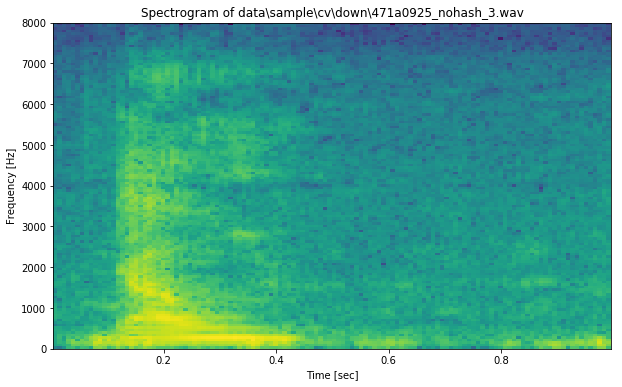

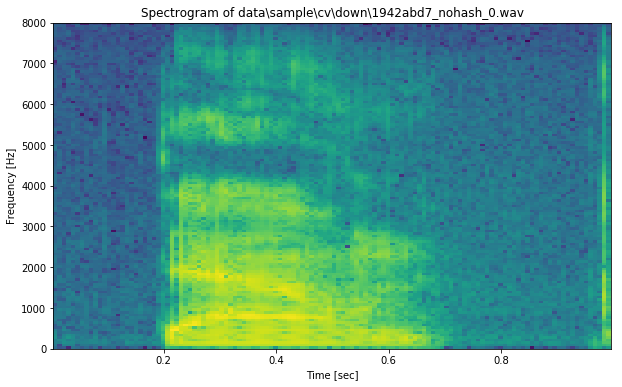

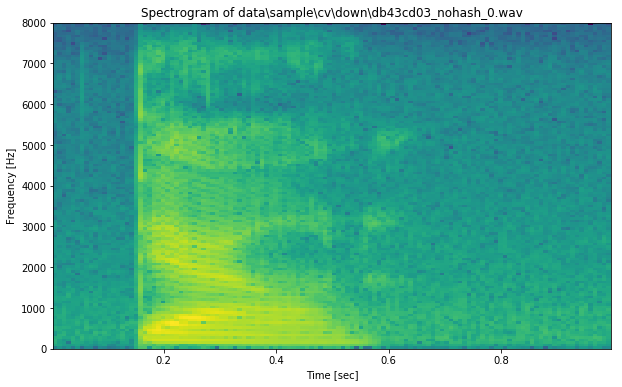

In [89]:
# Down
graph_spectrogram(path_to_down_1)
graph_spectrogram(path_to_down_2)
graph_spectrogram(path_to_down_3)

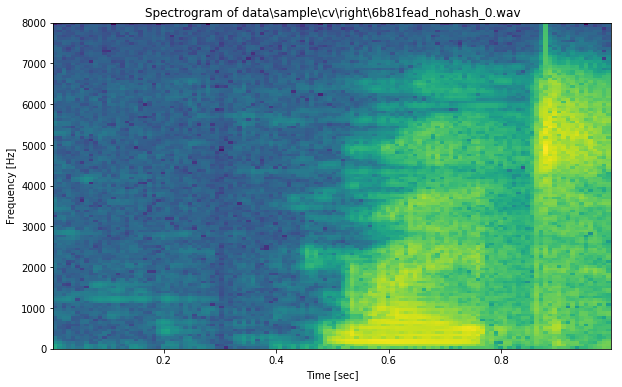

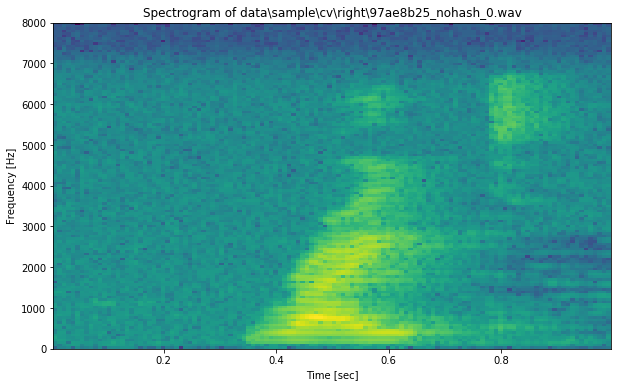

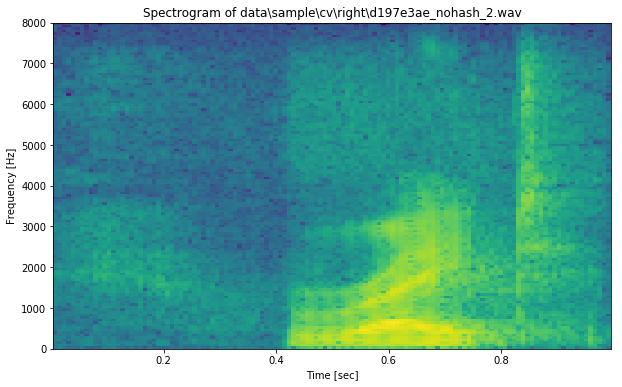

In [90]:
# Right
graph_spectrogram(path_to_right_1)
graph_spectrogram(path_to_right_2)
graph_spectrogram(path_to_right_3)

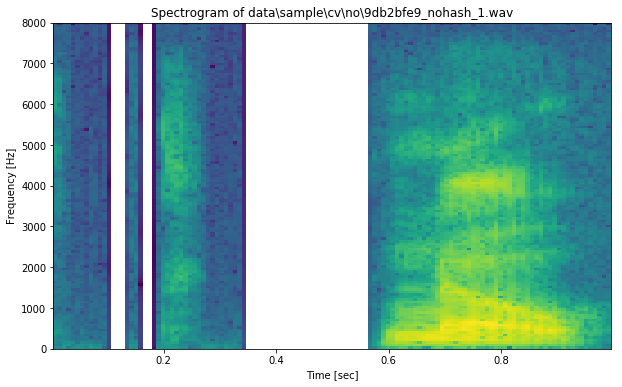

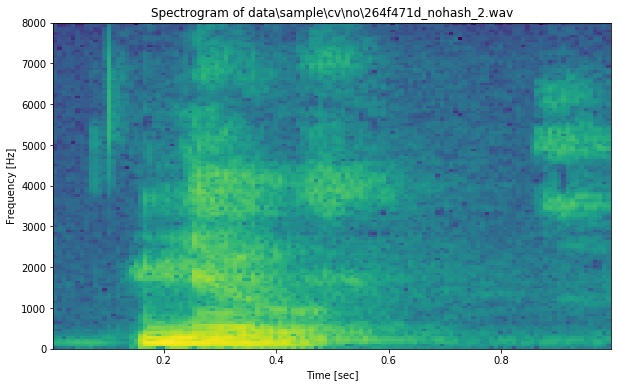

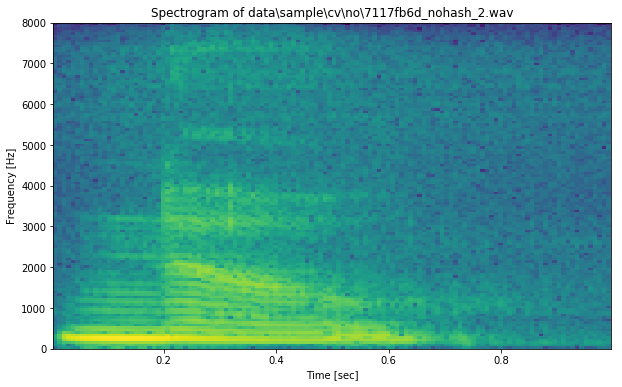

In [91]:
# No
graph_spectrogram(path_to_no_1)
graph_spectrogram(path_to_no_2)
graph_spectrogram(path_to_no_3)

With spectrograms it seems that the difference is more pronounced and therefore they are a more promising candidates for multilayer convolutional models, which can pick up on quite complex visual patterns.

#### MEL Spectrograms
Let's repeat the procedure for the MEL spectrograms.

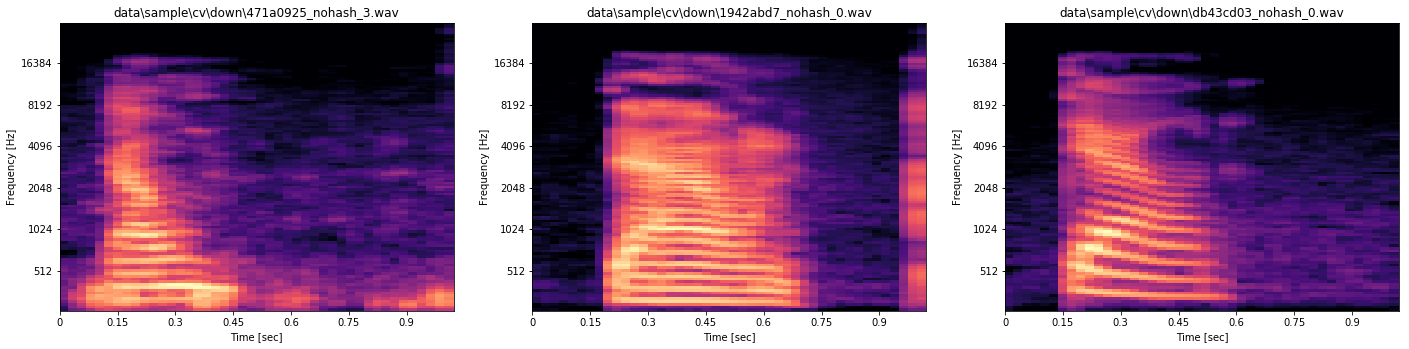

In [104]:
# Down
graph_multiple_mel_spectrograms([path_to_down_1, path_to_down_2, path_to_down_3])

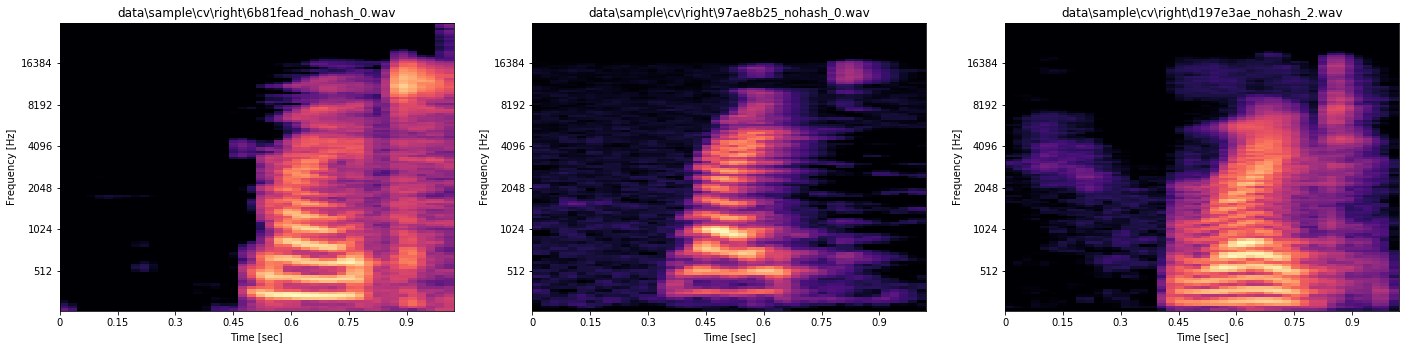

In [105]:
# Right
graph_multiple_mel_spectrograms([path_to_right_1, path_to_right_2, path_to_right_3])

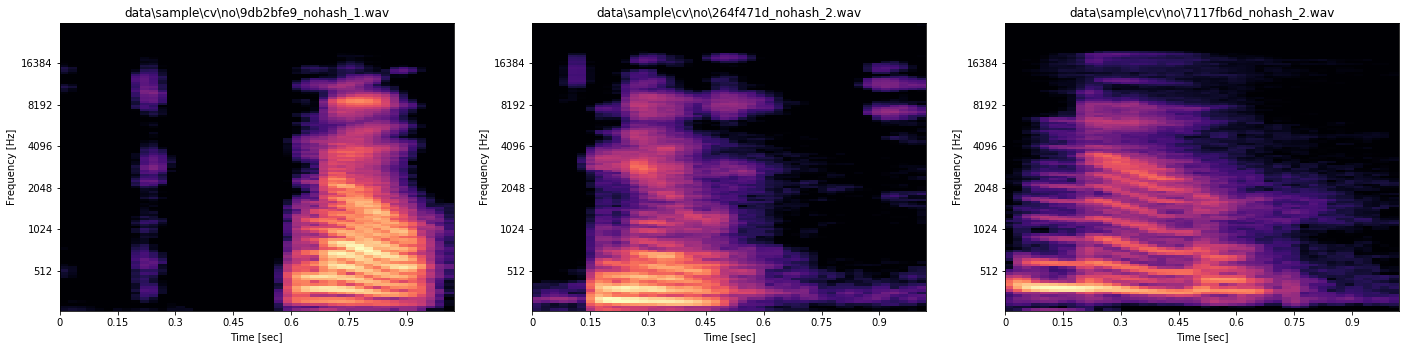

In [106]:
# No
graph_multiple_mel_spectrograms([path_to_no_1, path_to_no_2, path_to_no_3])

Despite the relatively low resolution we can also see certain visual patterns here, although they aren't very pronounced. Since we plan to test viable approaches on the sample set we can afford to experiment with even moderately promising strategies.

### Visualize a category
Let's try to visualize more examples from the same category, side by side.

In [102]:
# 5 paths to "left"
path_to_left_1 = os.path.join(path_to_sample, "cv\\left\\5fadb538_nohash_1.wav")
path_to_left_2 = os.path.join(path_to_sample, "cv\\left\\9cde5de8_nohash_1.wav")
path_to_left_3 = os.path.join(path_to_sample, "cv\\left\\bfbd0e6b_nohash_0.wav")
path_to_left_4 = os.path.join(path_to_sample, "cv\\left\\d197e3ae_nohash_0.wav")
path_to_left_5 = os.path.join(path_to_sample, "cv\\left\\e14a99a5_nohash_0.wav")

# Grab a 6th path to "left" from main, for symmetry
path_main_train = "data\\main\\train"
path_to_left_6 = os.path.join(path_main_train, "left\\0b56bcfe_nohash_0.wav")

# Put them in one list
paths_to_left = [path_to_left_1, path_to_left_2, path_to_left_3, 
                 path_to_left_4, path_to_left_5, path_to_left_6]

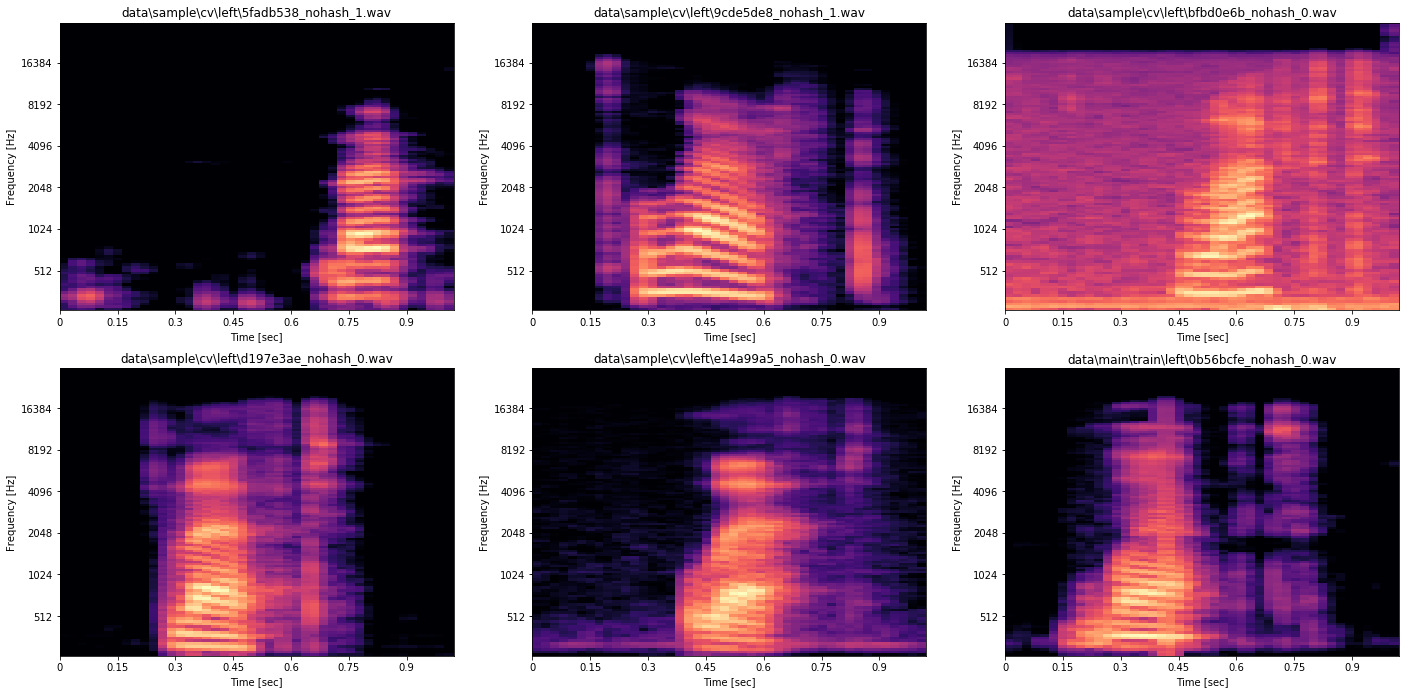

In [103]:
graph_multiple_mel_spectrograms(paths_to_left)

We can arguably see that the spectrograms belonging to the **left** category all have a black vertical line about two thirds into the utterance. It seems least pronounced in the first example (top left corner). This would correspond to the short silence before pronouncing the "t".

We can also see that the top right example (nr 3) has a different colored background. Let's investigate:

In [107]:
display_audio(path_to_left_3)

At first auditory glance this sample has a lot of non-zero background noise. We can compare it to example 4, which has a very uniform black background on the spectrogram.

In [108]:
display_audio(path_to_left_4)

It seems that in accordance with our hypothesis a more "noisy" background image corresponds to background noise in the audio sample.

This could interfere with our image pattern recognition algorithms which is a good argument for augmenting our data usin the provided background noise samples, which we can try further along the process of preprocessing our data.

### Chromatisation
Also show this as an alternative

### Rename
We should consider calling this one investigation and visualization and then do sample preprocessing which will include mixing in background noise. But I think first we should try to run some simple models on the MELs in the sample